# Transfer learning with pytorch

#### Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [4]:
cudnn.benchmark = True
plt.ion()

#### Load the data

Data augmentation and normalization for training

Only data normalization for validating

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [11]:
data_dir = 'hymenoptera_data'

images_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}
data_loaders = {
    x: torch.utils.data.DataLoader(images_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']
}
datasets_sizes = {
    x: len(images_datasets[x]) for x in ['train', 'val']
}
class_names = images_datasets['train'].classes

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##### Visualize some images

In [13]:
inputs, classes = next(iter(data_loaders['train']))

In [14]:
out = torchvision.utils.make_grid(inputs)

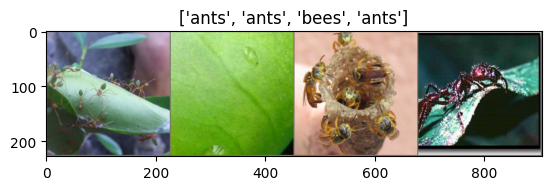

In [16]:
img = out.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title([class_names[x] for x in classes])
plt.pause(0.001)

#### Fine tuning the convnet

In [17]:
model_features = models.resnet18(pretrained=True)
num_features = model_features.fc.in_features

/home/yanir/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yanir/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yanir/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Set the last layer to the number of classes we have i.e 2 for `bees` and `ants`

In [18]:
model_features.fc = nn.Linear(num_features, len(class_names))

In [19]:
model_features = model_features.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
optimizer_features = optim.SGD(model_features.parameters(), lr=0.001, momentum=0.9)

In [22]:
exponential_learning_rate_scheduler = lr_scheduler.StepLR(optimizer_features, step_size=7, gamma=0.1)

#### Train the model

In [23]:
model = model_features
criterion = criterion
optimizer = optimizer_features
scheduler = exponential_learning_rate_scheduler
num_epochs=25

In [24]:
start_time = time.time()

best_model_weights = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        {'train': model.train, 'val': model.eval}[phase]()
        
        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in data_loaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / datasets_sizes[phase]
        epoch_acc = running_corrects.double() / datasets_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
        
    print()

time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

model.load_state_dict(best_model_weights)

Epoch 0/24
----------
train Loss: 0.6098 Acc: 0.6639
val Loss: 0.2119 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4533 Acc: 0.8402
val Loss: 0.2564 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4930 Acc: 0.8115
val Loss: 0.2188 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4513 Acc: 0.8197
val Loss: 0.2122 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4773 Acc: 0.8156
val Loss: 0.2349 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5142 Acc: 0.8156
val Loss: 0.1720 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4532 Acc: 0.8279
val Loss: 0.4175 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3338 Acc: 0.8566
val Loss: 0.3389 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.4291 Acc: 0.8443
val Loss: 0.3149 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2908 Acc: 0.8730
val Loss: 0.2718 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3617 Acc: 0.8443
val Loss: 0.2257 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2851 Acc: 0.8852
val Loss: 0.2318 Acc: 0.9346

Ep

<All keys matched successfully>

#### Visualize the model predictions

In [25]:
num_images = 6

In [32]:
was_training = model.training
model.eval()
images_displayed = 0
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

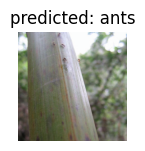

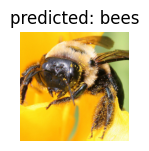

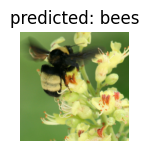

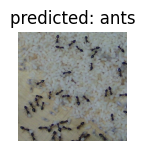

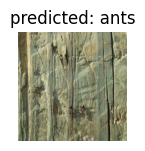

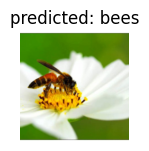

In [33]:
with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_displayed += 1
            ax = plt.subplot(num_images // 2, 2, images_displayed)
            ax.axis('off')
            ax.set_title(f'predicted: {class_names[preds[j]]}')

            img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            plt.pause(0.001)

            if images_displayed == num_images:
                model.train(mode=was_training)
                break
        
        if images_displayed == num_images:
            break

    model.train(mode=was_training)